# Figure S7A


# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import pandas as pd
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Definitions

Function to plot togher experimental data and model predictions obtained in the different cell types

In [2]:
def plot_celltypes(data_exp, data_model, col, axs, avg=True): 
    
    mean_data_exp = np.nanmean(data_exp)
    mean_data_model = np.nanmean(data_model)
    std_data_exp = np.nanstd(data_exp)
    std_data_model = np.nanstd(data_model)
    
    x = np.random.normal(1, 0.08, size=len(data_exp))
    axs.plot(x,data_exp,'.', color= col, alpha=0.3, markersize=10, zorder=1) 
     
    x = np.random.normal(2, 0.08, size=len(data_model))
    axs.plot(x,data_model,'.', color= col, alpha=0.3, markersize=10, zorder=1)
    
    if avg==True:
        x = 1 
        axs.errorbar(x,mean_data_exp ,std_data_exp, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)
   
        x = 2 
        axs.errorbar(x,mean_data_model ,std_data_model, marker='o',markersize=5,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

Function to define the properties of the axis of a plot

In [3]:
def my_axsis(ax, xlim, ylim, xticks, title, xtickslabels, bold=True, scale='lin'):    
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_title(title)
    ax.set_xticklabels(xtickslabels)
    
    if bold==True:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)
            
    if scale=='log':
        ax.set_yscale('log', base=2)

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

The evolution equation for T 

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T)

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

Evolution equation for the activator Ap

In [8]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=9,Er_v=0.5,KMM3_v=0.3,vMM4_v=1,KMM4_v=0.3):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [9]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=18,Er_v=0.5,KMM1_v=0.15,vMM2_v=1,KMM2_v=0.15): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [10]:
expr_Otx = vb+ vo*Ap**2/((Ka*(1+I/Ki))**2+Ap**2)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Import the experimental data 

In [11]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

data_Fig3A = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Fig 3A & S3A')
df_Fig3A = pd.DataFrame(data_Fig3A)

Area of cell surface in contact with FGF (S1)  

In [12]:
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

Experimental data figure 3A

In [14]:
# Levels of Otx expression (divided by cell types) 
a65_Otx = np.array(df_Fig3A['a6.5'].values.tolist())
a66_Otx = np.array(df_Fig3A['a6.6'].values.tolist())
a67_Otx = np.array(df_Fig3A['a6.7'].values.tolist())
a68_Otx = np.array(df_Fig3A['a6.8'].values.tolist())

alldata_Otx = np.concatenate((a65_Otx,a66_Otx,a67_Otx,a68_Otx))

# Compute the mean of the experimental data
a65_Otx_mean = np.nanmean(a65_Otx)
a66_Otx_mean = np.nanmean(a66_Otx)
a67_Otx_mean = np.nanmean(a67_Otx)
a68_Otx_mean = np.nanmean(a68_Otx)

# Compute the standard deviation of the experimental data
a65_Otx_std = np.nanstd(a65_Otx)
a66_Otx_std = np.nanstd(a66_Otx)
a67_Otx_std = np.nanstd(a67_Otx)
a68_Otx_std = np.nanstd(a68_Otx)

mean_Otx = [a65_Otx_mean, a66_Otx_mean, a67_Otx_mean, a68_Otx_mean]
std_Otx = [a65_Otx_std, a66_Otx_std, a67_Otx_std, a68_Otx_std]

# Results

## Figure S7A

### Model predictions

Compute Otx expression

In [15]:
# Compute T 
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk activity
Erk_pred_a65 = Erk(T_pred_a65)
Erk_pred_a66 = Erk(T_pred_a66)
Erk_pred_a67 = Erk(T_pred_a67)
Erk_pred_a68 = Erk(T_pred_a68)

# Compute Ap
Ap_pred_a65 = [exprAp(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
Ap_pred_a66 = [exprAp(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
Ap_pred_a67 = [exprAp(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
Ap_pred_a68 = [exprAp(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute I
I_pred_a65 = [exprI(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
I_pred_a66 = [exprI(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
I_pred_a67 = [exprI(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
I_pred_a68 = [exprI(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute Otx expression
Otx_pred_a65_e = np.array(exprOtx(Ap_v=Ap_pred_a65,I_v=I_pred_a65)).astype(float)
Otx_pred_a66_e = np.array(exprOtx(Ap_v=Ap_pred_a66,I_v=I_pred_a66)).astype(float)
Otx_pred_a67_e = np.array(exprOtx(Ap_v=Ap_pred_a67,I_v=I_pred_a67)).astype(float)
Otx_pred_a68_e = np.array(exprOtx(Ap_v=Ap_pred_a68,I_v=I_pred_a68)).astype(float)

# Compute mean
a65_Otx_mean_pred_e = np.mean(Otx_pred_a65_e)
a66_Otx_mean_pred_e = np.mean(Otx_pred_a66_e)
a67_Otx_mean_pred_e = np.mean(Otx_pred_a67_e)
a68_Otx_mean_pred_e = np.mean(Otx_pred_a68_e)

# Compute std
a65_Otx_std_pred_e = np.std(Otx_pred_a65_e)
a66_Otx_std_pred_e = np.std(Otx_pred_a66_e)
a67_Otx_std_pred_e = np.std(Otx_pred_a67_e)
a68_Otx_std_pred_e = np.std(Otx_pred_a68_e)

mean_Otx_pred_e = [a65_Otx_mean_pred_e, a66_Otx_mean_pred_e, a67_Otx_mean_pred_e, a68_Otx_mean_pred_e]
std_Otx_pred_e = [a65_Otx_std_pred_e, a66_Otx_std_pred_e, a67_Otx_std_pred_e, a68_Otx_std_pred_e]

Compute Otx smFISH spots counts

In [16]:
# Compute Otx spot counts
Obas_value = a68_Otx_mean
Omax_value= 60

Otx_pred_a65_sc = np.array(exprOtx(Ap_v=Ap_pred_a65,I_v=I_pred_a65, Omax = Omax_value, Obas = Obas_value)).astype(float)
Otx_pred_a66_sc = np.array(exprOtx(Ap_v=Ap_pred_a66,I_v=I_pred_a66, Omax = Omax_value, Obas = Obas_value)).astype(float)
Otx_pred_a67_sc = np.array(exprOtx(Ap_v=Ap_pred_a67,I_v=I_pred_a67, Omax = Omax_value, Obas = Obas_value)).astype(float)
Otx_pred_a68_sc = np.array(exprOtx(Ap_v=Ap_pred_a68,I_v=I_pred_a68, Omax = Omax_value, Obas = Obas_value)).astype(float)

# Compute mean
a65_Otx_mean_pred_sc = np.mean(Otx_pred_a65_sc)
a66_Otx_mean_pred_sc = np.mean(Otx_pred_a66_sc)
a67_Otx_mean_pred_sc = np.mean(Otx_pred_a67_sc)
a68_Otx_mean_pred_sc = np.mean(Otx_pred_a68_sc)

# Compute std
a65_Otx_std_pred_sc = np.sqrt(Omax_value**2*a65_Otx_std_pred_e**2+a68_Otx_std**2)
a66_Otx_std_pred_sc = np.sqrt(Omax_value**2*a66_Otx_std_pred_e**2+a68_Otx_std**2)
a67_Otx_std_pred_sc = np.sqrt(Omax_value**2*a67_Otx_std_pred_e**2+a68_Otx_std**2)
a68_Otx_std_pred_sc = np.sqrt(Omax_value**2*a68_Otx_std_pred_e**2+a68_Otx_std**2)

mean_Otx_pred_sc = [a65_Otx_mean_pred_sc, a66_Otx_mean_pred_sc, a67_Otx_mean_pred_sc, a68_Otx_mean_pred_sc]
std_Otx_pred_sc = [a65_Otx_std_pred_sc, a66_Otx_std_pred_sc, a67_Otx_std_pred_sc, a68_Otx_std_pred_sc]

### Comparison with experimental data 

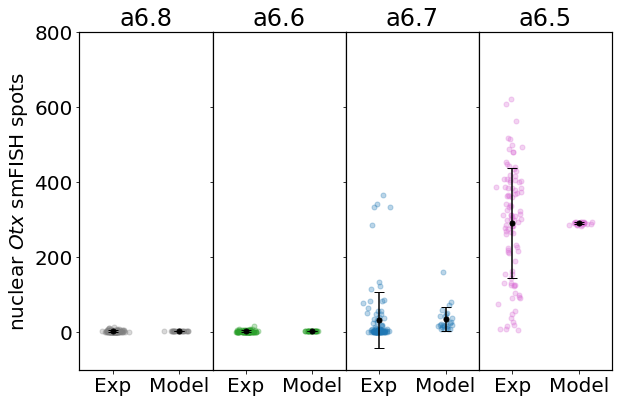

In [17]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,4, hspace=0,wspace=0)
axs = gs.subplots(sharey=True)

# a6.8 
ax = axs[0]
plot_celltypes(a68_Otx, Otx_pred_a68_sc, col='grey', axs=ax, avg=True)
ax.set_ylabel('nuclear $Otx$ smFISH spots')
my_axsis(axs[0], xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.8', xtickslabels=['Exp', 'Model'])

# a6.6 
ax = axs[1]
plot_celltypes(a66_Otx, Otx_pred_a66_sc, col='tab:green', axs=ax, avg=True)
my_axsis(axs[1], xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.6', xtickslabels=['Exp', 'Model'])

# a6.7 
ax = axs[2]
plot_celltypes(a67_Otx, Otx_pred_a67_sc, col='tab:blue', axs=ax, avg=True)
my_axsis(axs[2], xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.7', xtickslabels=['Exp', 'Model'])

# a6.5
ax = axs[3]
plot_celltypes(a65_Otx, Otx_pred_a65_sc, col='orchid', axs=ax, avg=True)
my_axsis(axs[3], xlim=[0.5,2.5], ylim=[-100,800], xticks=[1,2], title='a6.5', xtickslabels=['Exp', 'Model'])

plt.tight_layout()
plt.show()